<a href="https://colab.research.google.com/github/abyanjan/Age-Gender-Prediction-with-CNN/blob/master/age_gender_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MULTI - OUTPUT MODELING WITH TENSORFLOW/KERAS

## AGE - GENDER PREDICTION WITH CONVOLUTIONAL NUERAL NETWORK

### DOWNLOAD DATA FROM KAGGLE

In [ ]:
!pip install -q kaggle

In [ ]:
# upload the kaggle.json file that has the api key
from google.colab import files
files.upload()

In [ ]:
!mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# download data
!kaggle datasets download -d jangedoo/utkface-new

 97% 321M/331M [00:10<00:00, 25.7MB/s]
100% 331M/331M [00:10<00:00, 32.6MB/s]


In [ ]:
# unzip the data folder
!unzip utkface-new.zip

### DATA PREPARATION

In [ ]:



for dirname, _, filenames in os.walk('/content/crop_part1'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

/content/crop_part1/10_1_0_20170109204502951.jpg.chip.jpg


In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
# stating the base path where the images are stores
base_path = "/content/utkface_aligned_cropped/crop_part1"

# list all the images
imgs = os.listdir(base_path)

# number of images
print(f"Total Number of Images: {len(imgs)}")

Total Number of Images: 9780


In [ ]:
# print to see how an image file name look
print(imgs[0])

58_0_1_20170109015140121.jpg.chip.jpg


The file path format represents the following : age_gender_ethnicity_datetime. We will be only working with age and gender, so we will extract age and gender from the image paths.

In [ ]:
# extracting age and gender
images_list = []
age = []
gender = []

for file in imgs:
    file_split = file.split("_")
    # checking if the file paths in correct format
    if len(file_split) > 1:
        images_list.append(file)
        age.append(file_split[0])
        gender.append(file_split[1])

In [ ]:
# storing the results in a data frame
df = pd.DataFrame({'Image':images_list, 'Age':age, 'Gender': gender})
df['Age'] = df['Age'].astype('int')
df['Gender'] = df['Gender'].astype('int')
df.head()

,Image,Age,Gender
0,58_0_1_20170109015140121.jpg.chip.jpg,58,0
1,27_1_4_20170103230157624.jpg.chip.jpg,27,1
2,1_0_2_20161219222119639.jpg.chip.jpg,1,0
3,31_0_3_20170104165548728.jpg.chip.jpg,31,0
4,45_1_0_20170103183543298.jpg.chip.jpg,45,1


**Exploring the Age Distribution**

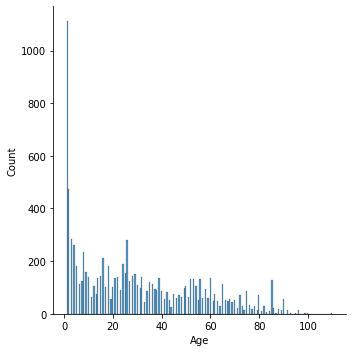

In [ ]:
# exploring the age distribution
#plt.figure(figsize = (15, 6))
sns.displot(df.Age, bins = 200)

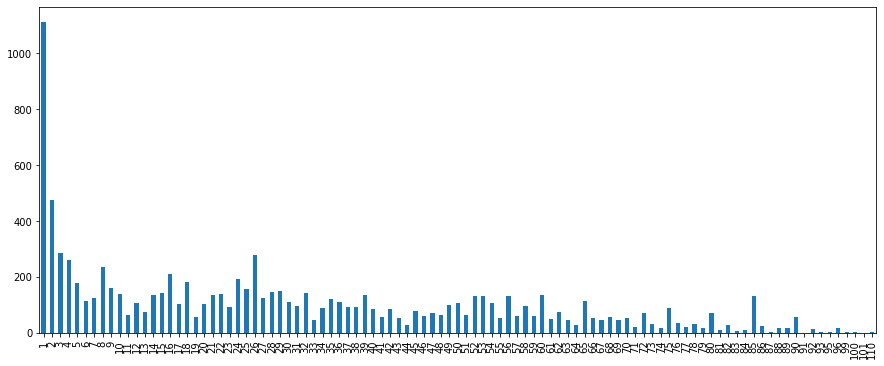

In [ ]:
plt.figure(figsize=(15,6))
df.Age.value_counts().sort_index().plot(kind = 'bar')

We can see that the distrubution of Age is very random, some Age are highly represented, while some are very few. So, we will be splitting the Age into buckets for better representation.

In [ ]:
# creating Age Buckets
age_buckets = [1,2,5,8,11,15,19,24,28,33,38,45,50,55,60,70,80,110]
age_group = ["1-2","3-5","6-8","9-11","12-15","16-19","20-24","25-28","29-33","34-38",
             "39-45","46-50","51-55","56-60","61-70","71-80","80 above"]
df['Age_group'] = pd.cut(df.Age, bins=age_buckets, right=True, include_lowest=True,
                        labels = age_group)

In [ ]:
df.head()

,Image,Age,Gender,Age_group
0,58_0_1_20170109015140121.jpg.chip.jpg,58,0,56-60
1,27_1_4_20170103230157624.jpg.chip.jpg,27,1,25-28
2,1_0_2_20161219222119639.jpg.chip.jpg,1,0,1-2
3,31_0_3_20170104165548728.jpg.chip.jpg,31,0,29-33
4,45_1_0_20170103183543298.jpg.chip.jpg,45,1,39-45


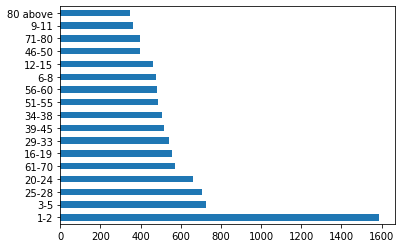

In [ ]:
df.Age_group.value_counts().plot(kind = 'barh')

**Visualizing Images**

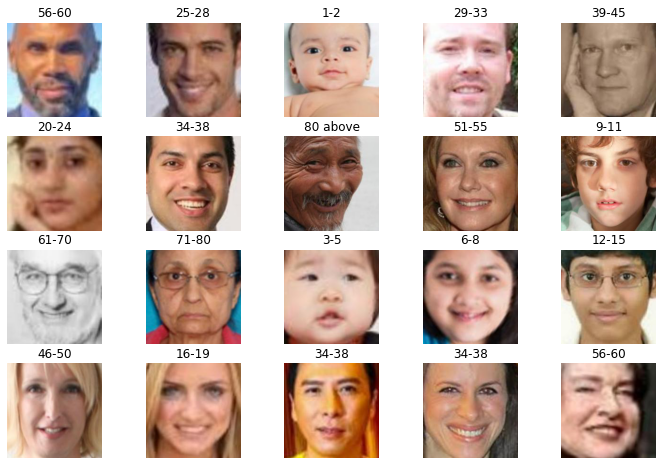

In [ ]:
# plot image from a age group
fig, ax = plt.subplots(4,5, figsize = (12,8))
ax = ax.ravel()
age = df.Age_group.unique()
for i in range(20):
    if i < len(age):
        img_path = df[df.Age_group == age[i]]['Image']  
        img = plt.imread(os.path.join(base_path, img_path.iloc[i]))
        ax[i].imshow(img)
        ax[i].set_title(age[i])
        ax[i].axis('off')
    else:
        age_index = np.random.randint(0,len(age)-1)
        img_path = df[df.Age_group == age[age_index]]['Image']
        img = plt.imread(os.path.join(base_path, img_path.iloc[i]))
        ax[i].imshow(img)
        ax[i].set_title(age[age_index])
        ax[i].axis('off')

In [ ]:
# check the size of an image
img = plt.imread(os.path.join(base_path, df.Image[1]))
img.shape

(200, 200, 3)

In [ ]:
df.shape

(9780, 4)

As we saw above age groups 1-2 had high counts compared to other,therefore, to overcome the imbalance data problem, we can try to reduce them by taking only random 50% of the data from the group. 

In [ ]:
images_to_select = []
for age in df.Age_group.unique():
    temp_df = df[df['Age_group'] == age]
    if age == '1-2':
        img_select = temp_df.sample(frac = 0.5, random_state = 0)['Image']
    else:
        img_select = temp_df.sample(frac = 1.0, random_state = 0)['Image']
     
    images_to_select.extend(list(img_select))

In [ ]:
len(images_to_select)

8987

In [ ]:
images_to_select[:10]

['57_0_0_20170105184101967.jpg.chip.jpg',
 '60_1_0_20170110152939871.jpg.chip.jpg',
 '56_0_0_20170105173223037.jpg.chip.jpg',
 '59_1_0_20170110123116580.jpg.chip.jpg',
 '58_0_2_20170104213251605.jpg.chip.jpg',
 '60_1_0_20170110160643720.jpg.chip.jpg',
 '56_0_3_20170104232205049.jpg.chip.jpg',
 '59_1_3_20170109134346011.jpg.chip.jpg',
 '60_1_0_20170110123158902.jpg.chip.jpg',
 '60_0_0_20170104213241125.jpg.chip.jpg']

In [ ]:
# kee only the selected images
df_selected = df[df['Image'].isin(images_to_select)]
df_selected.shape

(8987, 4)

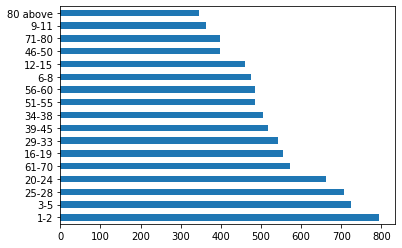

In [ ]:
df_selected.Age_group.value_counts().plot(kind='barh')

We now, have a better distribution of age group than before, where the distribution was highly dominated by 1-2 age group.

**Gender Distribution**

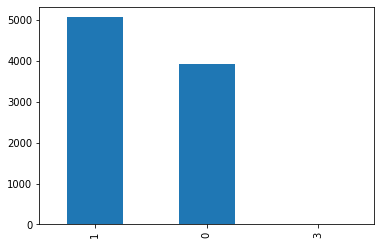

In [ ]:
df_selected.Gender.value_counts().plot(kind = 'bar')

We have some data for Gender with label 3, which is neglagible and so we will remove it. Otherwise the distribution is balanced and we can proceed with it.

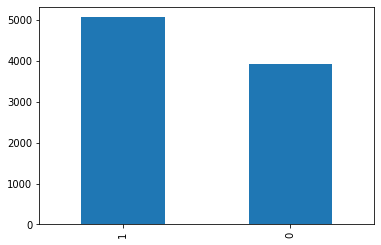

In [ ]:
# remove data with gender label 3
df_selected = df_selected[df_selected.Gender!=3]
df_selected.Gender.value_counts().plot(kind = 'bar')

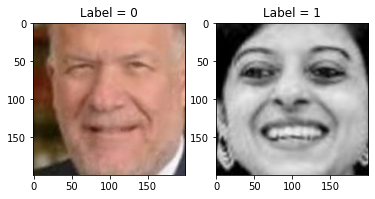

In [ ]:
# checking the labels for Gender

# plot an image for label 0
plt.subplot(1,2,1)
img_path = df[df.Gender == 0]['Image']
img = plt.imread(os.path.join(base_path, img_path.iloc[5]))
plt.imshow(img)
plt.title("Label = 0")

# plot an image for label 1
plt.subplot(1,2,2)
img_path = df[df.Gender == 1]['Image']
img = plt.imread(os.path.join(base_path, img_path.iloc[2]))
plt.imshow(img)
plt.title("Label = 1")

plt.show()

So, from the images, we can see that Label 0 is for Male and 1 is for Female.

### **Train Test Split**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

In [ ]:
# creating train and test split
train, test = train_test_split(df_selected, test_size = 0.3, stratify = df_selected.Age_group, 
                               random_state = 0)

print(train.shape, test.shape)

(6290, 4) (2696, 4)


In [ ]:
# create the target labels
train_gender = train.Gender.values
train_age = train.Age_group.values

test_gender = test.Gender.values
test_age = test.Age_group.values

In [ ]:
# Label encoding the age group
le = LabelBinarizer()
le.fit(train_age)

train_age = le.transform(train_age)
test_age = le.transform(test_age)

In [ ]:
train_age

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
le.classes_

array(['1-2', '12-15', '16-19', '20-24', '25-28', '29-33', '3-5', '34-38',
       '39-45', '46-50', '51-55', '56-60', '6-8', '61-70', '71-80',
       '80 above', '9-11'], dtype='<U8')

In [ ]:
train_age.shape

(6290, 17)

**Process the Images to Array**

In [ ]:
# Process the images to array
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
## prepare the images

# preparing train images
train_images = []
for file in train['Image']:
    img = load_img(os.path.join(base_path, file), target_size=(64,64))
    img = img_to_array(img)
    
    train_images.append(img)

In [ ]:
# convert to array and normalize the images
train_images = np.array(train_images, dtype = "float32")/255.0
train_images.shape

(6290, 64, 64, 3)

In [ ]:
# preparing test images
test_images = []
for file in test['Image']:
    img = load_img(os.path.join(base_path, file), target_size =(64,64))
    img = img_to_array(img)
   
    test_images.append(img)

In [ ]:
test_images = np.array(test_images, dtype = 'float32')/255.0
test_images.shape

(2696, 64, 64, 3)

**Create Tensorflow Dataset**

In [ ]:
from tensorflow.data import Dataset
from tensorflow.data import AUTOTUNE

In [ ]:
train_dataset = Dataset.from_tensor_slices((train_images, (train_gender, train_age)))
test_dataset = Dataset.from_tensor_slices((test_images, (test_gender, test_age)))

In [ ]:
#train_images = None
#test_images = None

In [ ]:
# mapping function to indicate the targets
def map_target(images, targets):
    return images, {"Gender":targets[0], "Age":targets[1]}

In [ ]:
# map the function to indicate the targets
train_dataset = train_dataset.map(map_target)
test_dataset = test_dataset.map(map_target)

In [ ]:
test_dataset.take(1)

<TakeDataset shapes: ((64, 64, 3), {Gender: (), Age: (17,)}), types: (tf.float32, {Gender: tf.int64, Age: tf.int64})>

In [ ]:
# prepare the batches of data
train_data = train_dataset.shuffle(10000).batch(64).prefetch(AUTOTUNE)
test_data = test_dataset.batch(64).prefetch(AUTOTUNE)

In [ ]:
#train_dataset = None
#test_dataset = None

### Modeling

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy, categorical_accuracy
from tensorflow.keras.metrics import binary_accuracy, binary_crossentropy, mean_absolute_error

In [ ]:
# define a base model for convolution operations
def cnn_model():
  model = Sequential()

  # Conv Block 1
  model.add(Conv2D(64, (3,3), padding='same', input_shape=(64,64,3)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))

  # Conv Block 2
  model.add(Conv2D(128,(5,5), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))

  # Conv Block 3
  model.add(Conv2D(512,(3,3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))

  # Conv Block 4
  model.add(Conv2D(512,(3,3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))

  model.add(Flatten())

  return model

In [ ]:
base_model =cnn_model()

In [ ]:
# outplut layer for Gender
gender_output = BatchNormalization()(base_model.output)
gender_output = Dropout(0.3)(gender_output)
#gender_output = Dense(128, activation = 'relu')(gender_output)
#gender_output = Dropout(0.3)(gender_output)
gender_output = Dense(64, activation = 'relu')(gender_output)
#gender_output = Dense(32, activation = 'relu')(gender_output)
gender_output = Dense(1, activation = 'sigmoid', name = "Gender")(gender_output)

In [ ]:
# outplut layer for Age
age_output = BatchNormalization()(base_model.output)
age_output = Dropout(0.3)(age_output)
#age_output = Dense(500, activation = 'relu')(age_output)
#age_output = Dropout(0.4)(age_output)
age_output = Dense(128, activation = 'relu')(age_output)
age_output = Dense(64, activation = 'relu')(age_output)
age_output = Dropout(0.4)(age_output)
#age_output = Dense(32, activation = 'relu')(age_output)
age_output = Dense(17, activation = 'softmax', name = "Age")(age_output)

In [ ]:
base_model.input

<KerasTensor: shape=(None, 64, 64, 3) dtype=float32 (created by layer 'conv2d_16_input')>

In [ ]:
final_model = tf.keras.Model(inputs = base_model.input, 
                             outputs = (gender_output, age_output))
final_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_16_input (InputLayer)    [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 64, 64, 64)   1792        conv2d_16_input[0][0]            
__________________________________________________________________________________________________
batch_normalization_24 (BatchNo (None, 64, 64, 64)   256         conv2d_16[0][0]                  
__________________________________________________________________________________________________
activation_16 (Activation)      (None, 64, 64, 64)   0           batch_normalization_24[0][0]     
____________________________________________________________________________________________

In [ ]:
# define the losses for each of the target outputs
losses = {
    "Gender": binary_crossentropy,
    "Age": categorical_crossentropy,
}

In [ ]:
# compile the model
final_model.compile(loss=losses, optimizer = Adam(learning_rate =  0.001), metrics = ['accuracy'])

In [ ]:
# callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau 
#from tensorflow.keras.callbacks import LearningRateScheduler

best_model = ModelCheckpoint(filepath='./best_model', save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, min_delta=0.001,  
                              patience = 4, mode = 'min', verbose = 1)

es = EarlyStopping(patience=10, min_delta=0.001, monitor = "val_loss",mode = 'min')

In [ ]:
history = final_model.fit(train_data, 
                          validation_data= test_data,
                          epochs = 60,
                          callbacks = [best_model, reduce_lr, es])

Epoch 1/60
99/99 [==============================] - 13s 107ms/step - loss: 3.8121 - Gender_loss: 0.8222 - Age_loss: 2.9899 - Gender_accuracy: 0.6801 - Age_accuracy: 0.1008 - val_loss: 3.7125 - val_Gender_loss: 0.8362 - val_Age_loss: 2.8763 - val_Gender_accuracy: 0.4340 - val_Age_accuracy: 0.0916
INFO:tensorflow:Assets written to: ./best_model/assets
Epoch 2/60
99/99 [==============================] - 11s 103ms/step - loss: 3.2520 - Gender_loss: 0.5855 - Age_loss: 2.6665 - Gender_accuracy: 0.7610 - Age_accuracy: 0.1467 - val_loss: 3.6045 - val_Gender_loss: 0.6581 - val_Age_loss: 2.9464 - val_Gender_accuracy: 0.6005 - val_Age_accuracy: 0.0386
INFO:tensorflow:Assets written to: ./best_model/assets
Epoch 3/60
99/99 [==============================] - 10s 102ms/step - loss: 2.8918 - Gender_loss: 0.4390 - Age_loss: 2.4528 - Gender_accuracy: 0.7952 - Age_accuracy: 0.1968 - val_loss: 3.2302 - val_Gender_loss: 0.5206 - val_Age_loss: 2.7096 - val_Gender_accuracy: 0.7548 - val_Age_accuracy: 0.1269

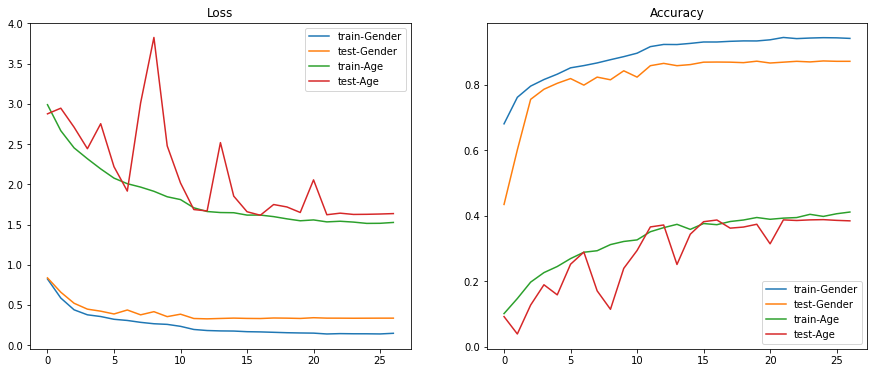

In [ ]:
# performance curve
plt.figure(figsize=(15,6))
epochs = history.epoch 
plt.subplot(1,2,1)
plt.plot(epochs, history.history['Gender_loss'], label = "train-Gender")
plt.plot(epochs, history.history['val_Gender_loss'], label = "test-Gender")
plt.plot(epochs, history.history['Age_loss'], label = "train-Age")
plt.plot(epochs, history.history['val_Age_loss'], label = "test-Age")
plt.title('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, history.history['Gender_accuracy'], label = "train-Gender")
plt.plot(epochs, history.history['val_Gender_accuracy'], label = "test-Gender")
plt.plot(epochs, history.history['Age_accuracy'], label = "train-Age")
plt.plot(epochs, history.history['val_Age_accuracy'], label = "test-Age")
plt.title('Accuracy')
plt.legend()

From the performance curve, we can see that the model is performing very good in predicting the gender, but it is poorly performing in predicting the age group, with a very low accuracy.

**Visualizing some of the predictions from test data**

In [ ]:
# load the best model
model = tf.keras.models.load_model('/content/best_model')

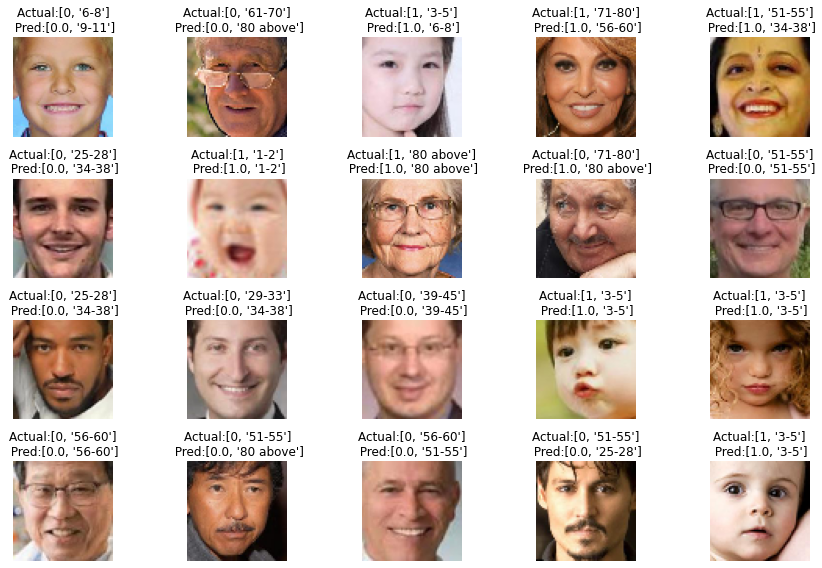

In [ ]:
# Visualizing some of the predictions from test data
# predictions on some random test images
n = 20
img_index = np.random.randint(0, len(test), n)
fig, ax = plt.subplots(4,5, figsize=(12, 8))
ax = ax.ravel()

for i in range(len(ax)):
  # load image
  img_path = test['Image'].iloc[img_index[i]]
  gender_label = test['Gender'].iloc[img_index[i]]
  age_label = test['Age_group'].iloc[img_index[i]]

  img = load_img(os.path.join(base_path, img_path), target_size=(64,64))
  img_pred = img_to_array(img)/255.0
  img_pred = np.expand_dims(img_pred,0 )
  true_label = f'Gender:{gender_label} Age:{age_label}'

  # prediction
  prediction = model.predict(img_pred)
  gender = np.round(prediction[0].item())
  age = le.classes_[np.argmax(prediction[1])]
  pred_label = f'Gender:{gender} Age:{age}'

  ax[i].imshow(img)
  ax[i].axis('off')
  ax[i].set_title(f'Actual:{[gender_label,age_label]}\n Pred:{[gender, age]}')
  
plt.tight_layout()

Since, our model is not performing very well in predicting the age group, that we arbitarilly created. We can try predicting the raw Age as it is with regression.

### Predicting the Age as numerical value

In [ ]:
# create the target labels
train_gender = train.Gender.values
train_age = train.Age.values

test_gender = test.Gender.values
test_age = test.Age.values

In [ ]:
# prepare tendorflow datasets
train_dataset = Dataset.from_tensor_slices((train_images, (train_gender, train_age)))
test_dataset = Dataset.from_tensor_slices((test_images, (test_gender, test_age)))

In [ ]:
# map the function to indicate the targets
train_dataset = train_dataset.map(map_target)
test_dataset = test_dataset.map(map_target)

In [ ]:
test_dataset.take(1)

<TakeDataset shapes: ((64, 64, 3), {Gender: (), Age: ()}), types: (tf.float32, {Gender: tf.int64, Age: tf.int64})>

In [ ]:
# prepare the batches of data
train_data = train_dataset.shuffle(10000).batch(64).prefetch(AUTOTUNE)
test_data = test_dataset.batch(64).prefetch(AUTOTUNE)

In [ ]:
#intantiate the base model
base_model = cnn_model()
base_model.input

<KerasTensor: shape=(None, 64, 64, 3) dtype=float32 (created by layer 'conv2d_40_input')>

**Update the output for the Age**

In [ ]:
# output layer for Age
age_output = BatchNormalization()(base_model.output)
age_output = Dropout(0.3)(age_output)
age_output = Dense(128, activation = 'relu')(age_output)
age_output = Dense(64, activation = 'relu')(age_output)
age_output = Dropout(0.4)(age_output)
age_output = Dense(1, activation = 'linear', name = "Age")(age_output)

In [ ]:
# outplut layer for Gender
gender_output = BatchNormalization()(base_model.output)
gender_output = Dropout(0.3)(gender_output)
gender_output = Dense(64, activation = 'relu')(gender_output)
gender_output = Dense(1, activation = 'sigmoid', name = "Gender")(gender_output)

In [ ]:
model_2 = tf.keras.Model(inputs = base_model.input, 
                             outputs = (gender_output, age_output))
final_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_16_input (InputLayer)    [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 64, 64, 64)   1792        conv2d_16_input[0][0]            
__________________________________________________________________________________________________
batch_normalization_24 (BatchNo (None, 64, 64, 64)   256         conv2d_16[0][0]                  
__________________________________________________________________________________________________
activation_16 (Activation)      (None, 64, 64, 64)   0           batch_normalization_24[0][0]     
____________________________________________________________________________________________

In [ ]:
# define the losses for each of the target outputs
losses = {
    "Gender": binary_crossentropy,
    "Age": mean_absolute_error,
}

In [ ]:
# compile the model
model_2.compile(loss=losses, optimizer = Adam(learning_rate =  0.001), metrics = ['accuracy'])

In [ ]:
# callbacks
best_model_2 = ModelCheckpoint(filepath='./best_model_2', save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, min_delta=0.001,  
                              patience = 4, mode = 'min', verbose = 1)

es = EarlyStopping(patience=10, min_delta=0.001, monitor = "val_loss",mode = 'min')

In [ ]:
history_2 = model_2.fit(train_data,
                        validation_data = test_data,
                        epochs = 60,
                        callbacks = [best_model_2, reduce_lr, es])

Epoch 1/60
99/99 [==============================] - 13s 104ms/step - loss: 18.9280 - Gender_loss: 0.8427 - Age_loss: 18.0852 - Gender_accuracy: 0.6563 - Age_accuracy: 0.0552 - val_loss: 20.9022 - val_Gender_loss: 0.9319 - val_Age_loss: 19.9703 - val_Gender_accuracy: 0.4340 - val_Age_accuracy: 0.0657
INFO:tensorflow:Assets written to: ./best_model_2/assets
Epoch 2/60
99/99 [==============================] - 10s 102ms/step - loss: 13.7116 - Gender_loss: 0.6184 - Age_loss: 13.0932 - Gender_accuracy: 0.7129 - Age_accuracy: 0.0564 - val_loss: 19.6812 - val_Gender_loss: 0.6264 - val_Age_loss: 19.0549 - val_Gender_accuracy: 0.6109 - val_Age_accuracy: 0.0657
INFO:tensorflow:Assets written to: ./best_model_2/assets
Epoch 3/60
99/99 [==============================] - 10s 100ms/step - loss: 11.7727 - Gender_loss: 0.5136 - Age_loss: 11.2591 - Gender_accuracy: 0.7482 - Age_accuracy: 0.0552 - val_loss: 15.9340 - val_Gender_loss: 0.6157 - val_Age_loss: 15.3183 - val_Gender_accuracy: 0.6595 - val_Age_

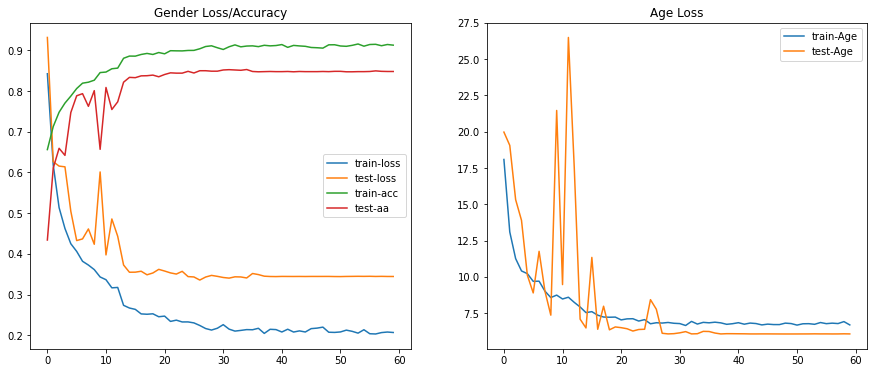

In [ ]:
# performance curve
plt.figure(figsize=(15,6))
epochs = history_2.epoch 
plt.subplot(1,2,1)
plt.plot(epochs, history_2.history['Gender_loss'], label = "train-loss")
plt.plot(epochs, history_2.history['val_Gender_loss'], label = "test-loss")
plt.plot(epochs, history_2.history['Gender_accuracy'], label = "train-acc")
plt.plot(epochs, history_2.history['val_Gender_accuracy'], label = "test-aa")
plt.title('Gender Loss/Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, history_2.history['Age_loss'], label = "train-Age")
plt.plot(epochs, history_2.history['val_Age_loss'], label = "test-Age")
plt.title('Age Loss')
plt.legend()

In [ ]:
# evaluation on test data
loss, gender_loss, age_loss, gender_accuracy, _ = model_2.evaluate(test_data)

43/43 [==============================] - 2s 33ms/step - loss: 6.4165 - Gender_loss: 0.3443 - Age_loss: 6.0722 - Gender_accuracy: 0.8483 - Age_accuracy: 0.0657


In [ ]:
print(f'Age Loss: {age_loss}')
print(f'Gender Accuracy : {gender_accuracy}')

Age Loss: 6.0721635818481445
Gender Accuracy : 0.8482937812805176


We can see that we have a good accuracy for gender prediction of around 85%. But the Age prediction is still not very good. The age prediction is on average off by around 6yrs.

**Visualizing some of the predictions**

In [ ]:
# load the best model
model = tf.keras.models.load_model('/content/best_model_2')

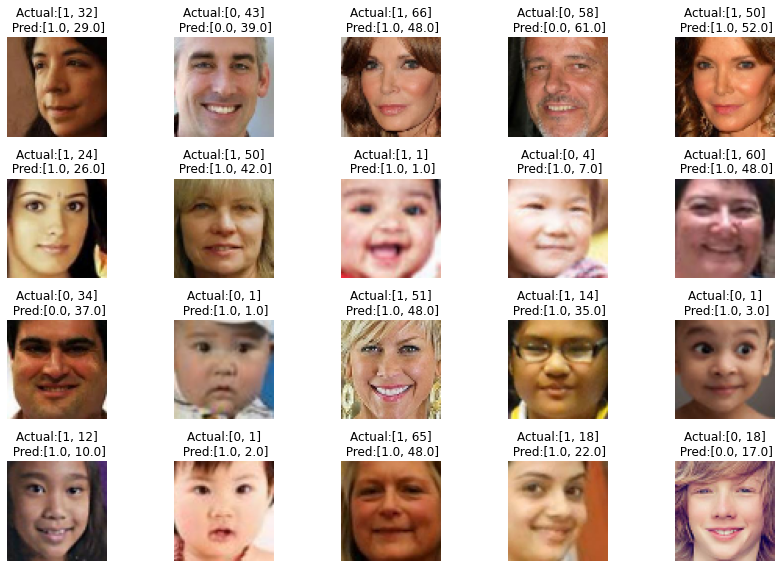

In [ ]:
# predictions on some random test images
n = 20
img_index = np.random.randint(0, len(test), n)
fig, ax = plt.subplots(4,5, figsize=(12, 8))
ax = ax.ravel()

for i in range(len(ax)):
  # load image
  img_path = test['Image'].iloc[img_index[i]]
  gender_label = test['Gender'].iloc[img_index[i]]
  age_label = test['Age'].iloc[img_index[i]]

  img = load_img(os.path.join(base_path, img_path), target_size=(64,64))
  img_pred = img_to_array(img)/255.0
  img_pred = np.expand_dims(img_pred,0 )
  true_label = f'Gender:{gender_label} Age:{age_label}'

  # prediction
  prediction = model.predict(img_pred)
  gender = np.round(prediction[0].item())
  age = np.round(prediction[1].item())
  pred_label = f'Gender:{gender} Age:{age}'

  ax[i].imshow(img)
  ax[i].axis('off')
  ax[i].set_title(f'Actual:{[gender_label,age_label]}\n Pred:{[gender, age]}')
  
plt.tight_layout()

We see from the results that the model is very good at corretly predciting the Gender, but does not perform very good at predicting the Age.